In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
#...

font = {'family' : 'times',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
class Experiment:
    def __init__(self, run):
        self.name = run.name
        self.config = run.config
        self.summary = run.summary
        self.history = run.history()
        self.tags = run.tags
        self.run = run
        
    def get_id(self):
        return (self.config['formula'],self.config['mol_idx'])
        
    def get_history(self):
        return np.array(list(self.history['additional_steps'])).cumsum()

In [3]:
def fetch(project):
    api = wandb.Api()
    entity = "some-random-foo"
    hdata = []
    runs = api.runs(entity + "/" + project)
    for run in tqdm(runs):
        try:
            hdata.append(Experiment(run))
        except:
            pass
    return hdata

In [12]:
raw = fetch("scale_master")


  0%|          | 0/415 [00:00<?, ?it/s]

In [13]:
# Loop through each Experiment object in raw and print details
for exp in raw:
    try:
        print(f"Name: {exp.name}")
        print(f"Config: {exp.config}")
        print(f"Summary: {exp.summary}")
        print(f"Tags: {exp.tags}")
        print(f"Run Group: {exp.run.group}")  # Assuming run.group gives the run group
        print(f"ID: {exp.get_id()}")
        print(f"History: {exp.get_history()}")
    except KeyError as e:
        print(f"KeyError encountered: {e}")

Name: schnet_ensemble_push_16_particles_2_devices
Config: {'model': 'schnet', 'train': 'ensemble_push', 'view_size': 16, 'batch_size': 20, 'cache_size': 8, 'num_device': 2, 'dataset size': 800, 'weight_decay': 0, 'learning_rate': 0.001, 'num_particles': 16}
Summary: {'time': 19.326848389002407, '_step': 7, '_runtime': 158.04212999343872, '_timestamp': 1695441091.029715, 'leader_loss:': 51691.4921875}
Tags: []
Run Group: a5000
KeyError encountered: 'formula'
Name: schnet_ensemble_push_8_particles_2_devices
Config: {'model': 'schnet', 'train': 'ensemble_push', 'view_size': 8, 'batch_size': 20, 'cache_size': 4, 'num_device': 2, 'dataset size': 800, 'weight_decay': 0, 'learning_rate': 0.001, 'num_particles': 8}
Summary: {'leader_loss:': 8070.8046875, 'time': 3.667302973997721, '_step': 9, '_wandb': {'runtime': 39}, '_runtime': 38.3410050868988, '_timestamp': 1695440910.9030662}
Tags: []
Run Group: a5000
KeyError encountered: 'formula'
Name: schnet_ensemble_push_4_particles_2_devices
Config

In [14]:
def get_exp(raw_exp, model):
    def test_method(method, exp):
        if method == "mswag_push" and "mswag_push" in exp.name:
            return True
        elif method == "svgd_push" and "svgd_push" in exp.name:
            return True
        elif method == "ensemble_push" and "ensemble_push" in exp.name:
            return True
        elif method == "ensemble" and "ensemble" in exp.name:
            return True
        elif method == "svgd" and "svgd" in exp.name:
            return True
        elif method == "mswag" and "mswag" in exp.name:
            return True
        else:
            return False
            
    exps = {'mswag_push': {dev: [] for dev in [1, 2, 4]},} 

    for exp in raw_exp:
        num_device = exp.config["num_device"]

        # For baseline methods
        if exp.run.group == "size" and exp.config["model"] == model:
            if test_method("mswag_push", exp):
                exps['mswag_push'][num_device] += [exp]
        if exp.run.group == "size3" and exp.config["model"] == model:
            if test_method("mswag_push", exp):
                exps['mswag_push'][num_device] += [exp]  
                
                
    return exps


In [15]:
def my_plot(model, method, exps, x_unit="", y_unit="", norm=False):
    plt.rcParams["font.family"] = "DejaVu Sans"
    
    def _one(exps, mswag):
        times = {}
        for exp in exps:
            try:
                if mswag:
                    times[exp.config["num_particles"]] = np.log2(exp.history["swag_epoch_time"].mean())
                else:
                    times[exp.config["num_particles"]] = np.log2(exp.history["time"].mean())
            except:
                pass

        myKeys = list(times.keys())
        myKeys.sort()
        ts = [times[i] for i in myKeys]
        return ts, myKeys

    plt.figure()
    
    if 1 in exps[method]:
        time_1, particles_1 = _one(exps[method][1], method == "mswag_push")
        plt.plot(np.log2(particles_1), time_1, marker='o', linestyle='-', label="1 Device")
    if 2 in exps[method]:
        time_2, particles_2 = _one(exps[method][2], method == "mswag_push")
        plt.plot(np.log2(particles_2), time_2, marker='s', linestyle='--', label="2 Devices")
    if 4 in exps[method]:
        time_4, particles_4 = _one(exps[method][4], method == "mswag_push")
        plt.plot(np.log2(particles_4), time_4, marker='^', linestyle=':', label="4 Devices") # Baseline
    
    
    plt.grid(True)  # Adding grid lines
    
    plt.ylim(-2, 8)
    plt.yticks(np.arange(11), [r'$2^{-2}$', r'$2^{-1}$', r'$2^{0}$', r'$2^1$', r'$2^2$', r'$2^3$', r'$2^4$', r'$2^5$', r'$2^6$', r'$2^7$', r'$2^8$'])
    plt.xticks(np.arange(10), [r'$2^0$', r'$2^1$', r'$2^2$', r'$2^3$', r'$2^4$', r'$2^5$', r'$2^6$', r'$2^7$', r'$2^8$', r'$2^9$',])
    plt.ylabel(f'Seconds ({y_unit} log scale)')
    plt.xlabel(f'Particles ({x_unit} log scale)')
    
    if method == "ensemble_push":
        method_title = "Ensemble"
    elif method == "mswag_push":
        method_title = "MSWAG"
    else:
        method_title = "Stein VGD"
    
    plt.title(f"{method_title} Push Scaling on {model}")
    plt.legend(loc='upper left') 
    plt.savefig(f'media/{model}_{method}.pdf', format='pdf')


# Example usage:
# my_plot("ModelName", "mswag_push", your_experiments_data, x_unit="Particles", y_unit="Seconds")


In [16]:
models = ["transformer2"]
methods = ["mswag_push"]

{'mswag_push': {1: [<__main__.Experiment object at 0x7fe07048b850>, <__main__.Experiment object at 0x7fe070488370>, <__main__.Experiment object at 0x7fe07048b670>, <__main__.Experiment object at 0x7fe070489450>, <__main__.Experiment object at 0x7fe070489780>, <__main__.Experiment object at 0x7fe070489fc0>, <__main__.Experiment object at 0x7fe070489de0>, <__main__.Experiment object at 0x7fe07048b520>, <__main__.Experiment object at 0x7fe07048ba60>], 2: [<__main__.Experiment object at 0x7fe069e2f040>, <__main__.Experiment object at 0x7fe069e501f0>, <__main__.Experiment object at 0x7fe069e514e0>, <__main__.Experiment object at 0x7fe069e51600>, <__main__.Experiment object at 0x7fe069e50130>, <__main__.Experiment object at 0x7fe069e2feb0>, <__main__.Experiment object at 0x7fe0704c7d00>, <__main__.Experiment object at 0x7fe0704c7a60>, <__main__.Experiment object at 0x7fe07048b250>], 4: [<__main__.Experiment object at 0x7fe07048b9d0>, <__main__.Experiment object at 0x7fe070488490>, <__main__.

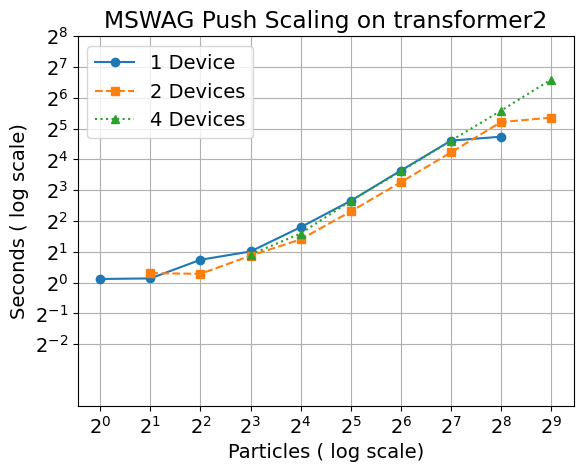

In [17]:
for model in models:
    for method in methods:
        exps = get_exp(raw, model)
        print(exps)
        my_plot(model, method, exps, norm=True)

In [10]:
def my_plot2(model, method, exps, x_unit="", y_unit="", norm=False):
    plt.rcParams["font.family"] = "DejaVu Sans"
    
    def _one(exps, mswag):
        times = {}
        for exp in exps:
            try:
                if mswag:
                    times[exp.config["num_params"]] = np.log2(exp.history["swag_epoch_time"].mean())
                else:
                    times[exp.config["num_params"]] = np.log2(exp.history["time"].mean())
            except:
                pass

        myKeys = list(times.keys())
        myKeys.sort()
        ts = [times[i] for i in myKeys]
        return ts, myKeys

    plt.figure()
    
    if 1 in exps[method]:
        time_1, params_1 = _one(exps[method][1], method == "mswag_push")
        plt.plot(params_1, time_1, marker='o', linestyle='-', label="1 Device")
    if 2 in exps[method]:
        time_2, params_2 = _one(exps[method][2], method == "mswag_push")
        plt.plot(params_2, time_2, marker='s', linestyle='--', label="2 Devices")
    if 4 in exps[method]:
        time_4, params_4 = _one(exps[method][4], method == "mswag_push")
        plt.plot(params_4, time_4, marker='^', linestyle=':', label="4 Devices")
    
    plt.grid(True)
    
    plt.ylim(-2, 8)
    plt.yticks(np.arange(11), [r'$2^{-2}$', r'$2^{-1}$', r'$2^{0}$', r'$2^1$', r'$2^2$', r'$2^3$', r'$2^4$', r'$2^5$', r'$2^6$', r'$2^7$', r'$2^8$'])
    plt.xticks(params_1 + params_2 + params_4)  # Assuming that params_1, params_2, and params_4 are the sorted num_params values
    
    plt.ylabel(f'Seconds ({y_unit} log scale)')
    plt.xlabel(f'Params ({x_unit})')
    
    if method == "ensemble_push":
        method_title = "Ensemble"
    elif method == "mswag_push":
        method_title = "MSWAG"
    else:
        method_title = "Stein VGD"
    
    plt.title(f"{method_title} Push Scaling on {model}")
    plt.legend(loc='upper left') 
    plt.savefig(f'media/{model}_{method}.pdf', format='pdf')

# Example usage: 
# my_plot("ModelName", "mswag_push", your_experiments_data, x_unit="Params", y_unit="Seconds")


{'mswag_push': {1: [<__main__.Experiment object at 0x7fe0789a2650>, <__main__.Experiment object at 0x7fe073ee8550>, <__main__.Experiment object at 0x7fe073ee88e0>, <__main__.Experiment object at 0x7fe073ee8d90>, <__main__.Experiment object at 0x7fe073ee8790>, <__main__.Experiment object at 0x7fe073ee9690>, <__main__.Experiment object at 0x7fe073ee9360>, <__main__.Experiment object at 0x7fe073ee9930>, <__main__.Experiment object at 0x7fe073ee9ed0>], 2: [<__main__.Experiment object at 0x7fe073a38520>, <__main__.Experiment object at 0x7fe073a38d00>, <__main__.Experiment object at 0x7fe073a3a890>, <__main__.Experiment object at 0x7fe073a396c0>, <__main__.Experiment object at 0x7fe073a39e40>, <__main__.Experiment object at 0x7fe073d1fcd0>, <__main__.Experiment object at 0x7fe073874340>, <__main__.Experiment object at 0x7fe073875990>, <__main__.Experiment object at 0x7fe0738756f0>], 4: [<__main__.Experiment object at 0x7fe0789a3e80>, <__main__.Experiment object at 0x7fe073ee84f0>, <__main__.

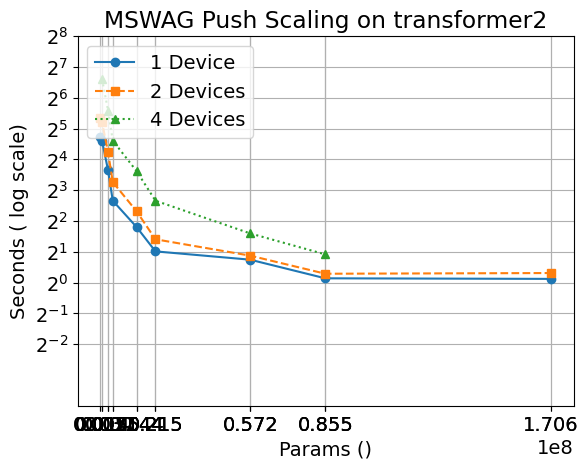

In [11]:
for model in models:
    for method in methods:
        exps = get_exp(raw, model)
        print(exps)
        my_plot2(model, method, exps, norm=True)

In [29]:
import pandas as pd
from IPython.core.display import display, HTML

# Initialize an empty list to hold the rows of your DataFrame
rows = []

# Loop through each Experiment object in raw and collect details
for exp in raw:
    try:
        group_size = exp.run.group  # Replace with the correct attribute if needed
        if exp.run.group == "size" or exp.run.group == "size3":
            num_params = exp.config.get('num_params', 'N/A')
            num_devices = exp.config.get('num_device', 'N/A')
            num_particles = exp.config.get('num_particles', 'N/A')
            time = exp.summary.get('_runtime', 'N/A')
        
            rows.append([num_params, num_devices, num_particles, time])
    except KeyError as e:
        print(f"KeyError encountered: {e}")

# Create a DataFrame from the list of rows
df = pd.DataFrame(rows, columns=['Number of Parameters', 'Number of Devices', 'Number of Particles', 'Time'])

# Sort the DataFrame by the 'Number of Particles' and 'Number of Devices' columns
df = df.sort_values(by=['Number of Particles', 'Number of Devices'])

# Convert the DataFrame to HTML
html_table = df.to_html(index=False)

# Display the HTML table in the notebook
display(HTML(html_table))


/tmp/ipykernel_852360/503469940.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Number of Parameters,Number of Devices,Number of Particles,Time
170575114,1,1,22.324180
85520650,1,2,22.636615
170575114,2,2,25.307335
57190666,1,4,34.266332
85520650,2,4,25.852353
21526666,1,8,40.909277
57190666,2,8,37.653230
85520650,4,8,38.325733
14439562,1,16,70.170900
21526666,2,16,53.480473
